## Final Project Submission

Please fill out:
* Student name: Jim Petoskey
* Student pace: Self-paced
* Scheduled project review date/time: Friday Feb 25, 2022 at 10:30 am 
* Instructor name: Abhineet Kulkarni
* Blog post URL: 
https://dev.to/jpetoskey/reap-return-on-home-remodel-35cm-temp-slug-7110869?preview=cfd57ff75f52f8f97d40012dae0383603926d95f772a119bd16af2d7e9d72c0486b48924df00a9b5660517361d1743d09317533548b17445419b7136


# Return on Renovation
* For homeowners looking to invest in their property, what renovations offer the best return?
    * This project explores a variety of home price predictors to recommend which renovations are likely to increase sale price.

# Exploring Data

In [306]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import MissingIndicator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore
import random

%matplotlib inline

In [307]:
house_df = pd.read_csv('data/kc_house_data.csv')
#column_names = pd.read_csv('data/column_names.md')

## What's in kc_house_data?

In [308]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [309]:
house_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


# First Model - Baseline

## Use 3-4 predictors from numerical data in the King County Housing data set to create baseline model.

In [310]:
# set numerical data in new data frame
numericals = house_df[['bedrooms', 
                       'bathrooms', 
                       'sqft_living', 
                       'sqft_lot', 
                       'floors',
                       'sqft_above',
                       'yr_built',
                       'yr_renovated',
                       'zipcode', 
                       'sqft_living15', 
                       'sqft_lot15']]

# set target column
y = house_df['price']

numericals.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,1180,1955,0.0,98178,1340,5650
1,3,2.25,2570,7242,2.0,2170,1951,1991.0,98125,1690,7639
2,2,1.00,770,10000,1.0,770,1933,NaN,98028,2720,8062
3,4,3.00,1960,5000,1.0,1050,1965,0.0,98136,1360,5000
4,3,2.00,1680,8080,1.0,1680,1987,0.0,98074,1800,7503


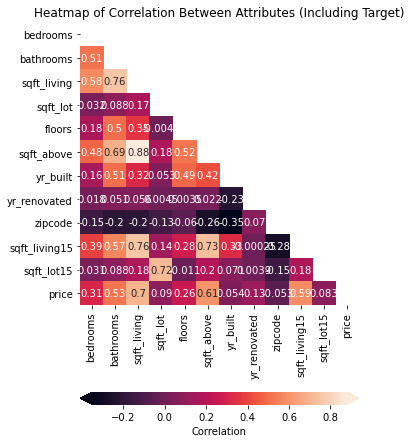

In [311]:
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = pd.concat([numericals, y], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(5, 8))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Build a model with the top three numerical values, then I will examine and likely add-in categoricals after one-hot-encoding the non-numericals.

* The top three predictors are: sqft_living, (dropping sqft_above and sqft_living15 - see explanation below), bathrooms, and bedrooms.

* I will drop two of the three sqft_living, sqft_living15, and sqft_above because they  exhibit strong correlation to each other and likely strong multicollinearity.  Considering sqft_living has a stronger correlation to price, which is our target, I will drop sqft_living15 and sqft_above.

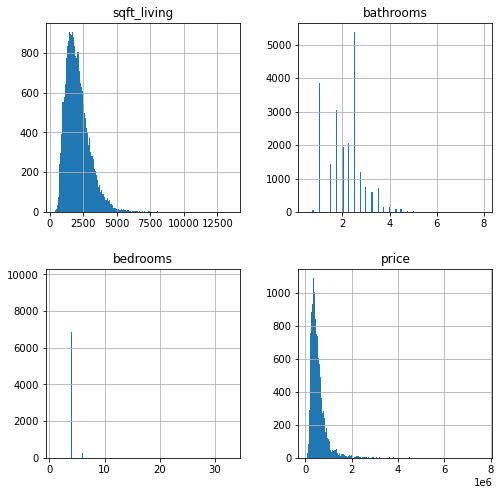

In [312]:
# Set top three numerical values
t3_numericals = house_df[['sqft_living', 'bathrooms', 'bedrooms', 'price']]

# Look at histograms for patterns
t3_numericals.hist(figsize = [8, 8], bins='auto');

### Log Tranformations
* Remove outliers later - especially in the bedrooms and sqft_living categories.

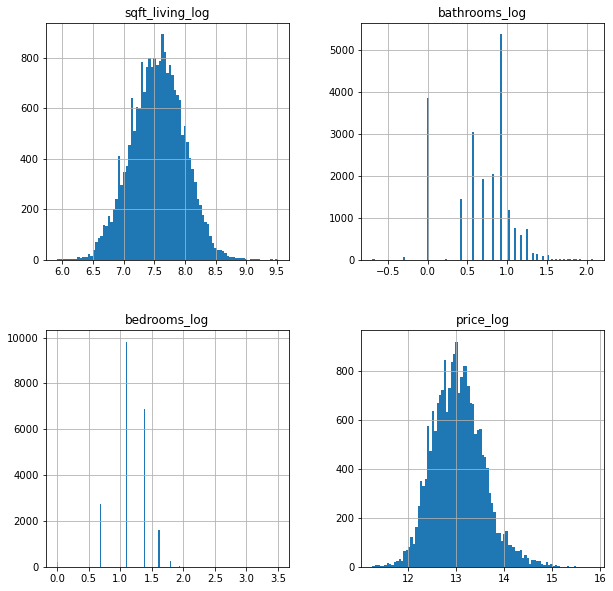

In [313]:
# Perform log transformations for t3_numericals 

log_names = [f'{column}_log' for column in t3_numericals.columns]

house_log = np.log(t3_numericals)
house_log.columns = log_names
house_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

### Normalization
* Skewness from outliers reduced with the log function performed.

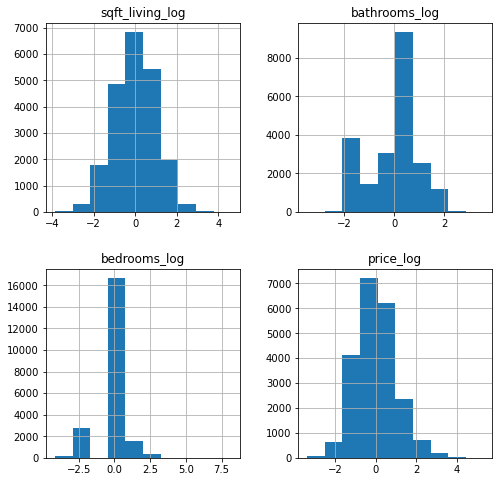

In [314]:
# Standardize the log features

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_final = house_log.apply(normalize)

features_final.hist(figsize  = [8, 8]);

In [359]:
features_final.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log
0,-1.125556,-1.726509,-0.279718,-1.401998
1,0.709446,0.339653,-0.279718,0.279938
2,-2.131893,-1.726509,-1.711611,-1.799430
3,0.070674,1.072635,0.736226,0.499698
4,-0.292725,0.039555,-0.279718,0.178434


In [360]:
# Model Summary
X = features_final.drop(['price_log'], axis=1)
y = features_final['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     6414.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:08:49   Log-Likelihood:                -23764.
No. Observations:               21597   AIC:                         4.754e+04
Df Residuals:                   21593   BIC:                         4.757e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.343e-15      0.005   2.71e-13      1.000      -0.010       0.010
sqft_living_log     0.7572      0.008     89.141      0.000       0.741       0.774
bathrooms_log       0.0325      0.008      4.244      0.000       0.017       0.047
bedrooms_log       -0.1652      0.007    -25.342      0.000      -0.178      -0.152
==============================================================================
Omnibus:                      104.465   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.162
Skew:                           0.139   Prob(JB):                     2.93e-22
Kurtosis:                       2.820   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [317]:
first_model = features_final

## Baseline Model - moderate R-squared value, good p-values, condition number, and identical Adjusted R-squared value.

* The R-squared value is not very high, but hopefully it will increase after I modify some of the data and include categorical variables.  This seems like a solid baseline model to work from as the p-values for the predictors fall far below the threshold of 5%, the condition number is low, indicating low multicollinearity, the standard errors are all far lower than the values of the coefficients, and the adjusted R-squared value is identical to the R-squared value, indicating we have a very low bias.

* As I alter the model, likely increasing complexity in order to increase the predictive capacity of the model, the adjusted R-squared value will probably not maintain equality or near-equality with the R-squared value.

# Preprocess Categorical Variables

Variable Descriptions for Categorical Variables.

In [318]:
# create categorical variable data set
categoricals = house_df[['waterfront', 
                         'view', 
                         'condition', 
                         'grade'
]]

## Dropped columns - id, date, sqft_basement.
* I dropped these columns because sqft_living is already incorporated into the model and other sqft categories had strong correlation with each other and would likely cause issues due to multicollinarity.

In [319]:
categoricals.describe

<bound method NDFrame.describe of       waterfront  view  condition          grade
0            NaN  NONE    Average      7 Average
1             NO  NONE    Average      7 Average
2             NO  NONE    Average  6 Low Average
3             NO  NONE  Very Good      7 Average
4             NO  NONE    Average         8 Good
...          ...   ...        ...            ...
21592         NO  NONE    Average         8 Good
21593         NO  NONE    Average         8 Good
21594         NO  NONE    Average      7 Average
21595        NaN  NONE    Average         8 Good
21596         NO  NONE    Average      7 Average

[21597 rows x 4 columns]>

## Plot categoricals to look for correlation to price.

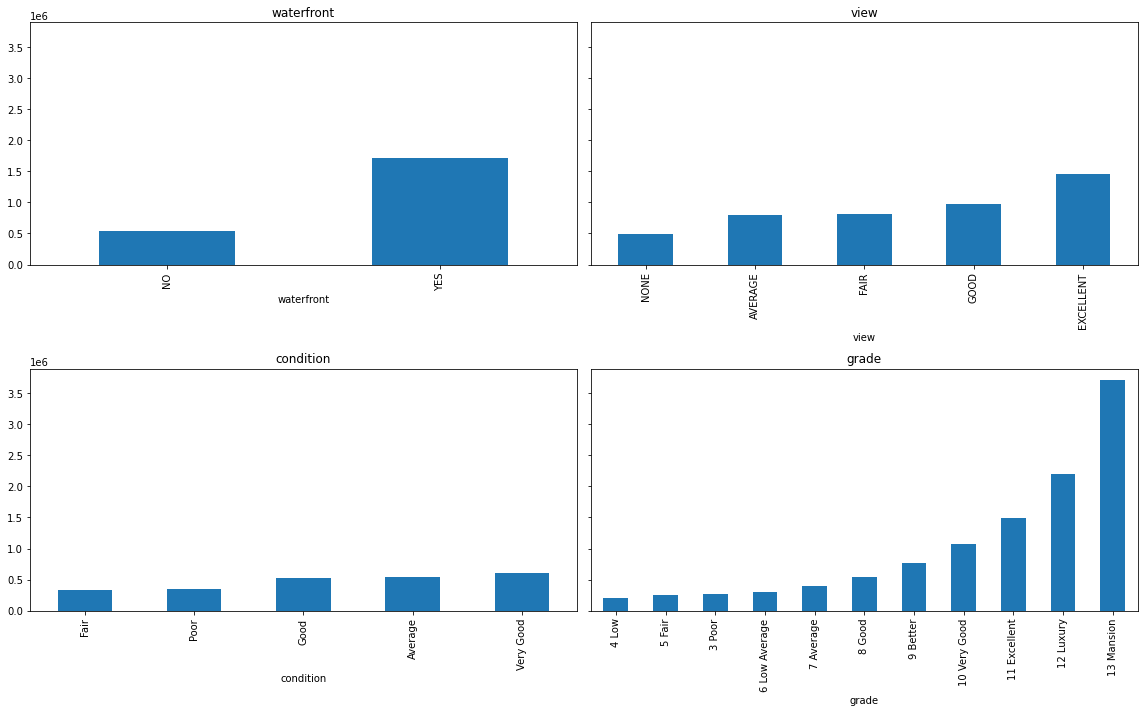

In [320]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (house_df.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### Promising Predictors - seem to correlate well with price from a visual inspection.

## Investigate nan values

In [321]:
categoricals.isnull().sum()

waterfront    2376
view            63
condition        0
grade            0
dtype: int64

In [322]:
# checking for nan values from categoricals['view']
categoricals['view'].value_counts(dropna=False)

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
NaN             63
Name: view, dtype: int64

In [323]:
# drops the whole row - removing some important data from other categories
# categoricals.dropna(subset=['waterfront'], inplace=True)

In [324]:
categoricals.isnull().sum()

waterfront    2376
view            63
condition        0
grade            0
dtype: int64

### Investigate nan values - waterfront

In [325]:
categoricals['waterfront'].value_counts(dropna=False)

NO     19075
NaN     2376
YES      146
Name: waterfront, dtype: int64

#### Create Missing Values Column - waterfront
* Saves nan information in the case that it is valuable later.

In [326]:
# (1) Identify data to be transformed
# We only want missing indicators for LotFrontage
waterfront_train = categoricals[["waterfront"]]

# (2) Instantiate the transformer object
missing_indicator = MissingIndicator()

# (3) Fit the transformer object on waterfront_train
missing_indicator.fit(waterfront_train)

# (4) Transform waterfront_train and assign the result
# to waterfront_missing_train
waterfront_missing_train = missing_indicator.transform(waterfront_train)

# Visually inspect waterfront_missing_train
waterfront_missing_train

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

##### Ensure waterfront_train is array of arrays containing True/False.

In [327]:
# waterfront_missing_train should be a NumPy array
assert type(waterfront_missing_train) == np.ndarray

# We should have the same number of rows as the full X_train
assert waterfront_missing_train.shape[0] == categoricals.shape[0]

# But we should only have 1 column
assert waterfront_missing_train.shape[1] == 1

In [328]:
# add the transformed data to the categorical data
categoricals["waterfront_missing"] = waterfront_missing_train
categoricals

<ipython-input-328-088c5258e668>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront_missing"] = waterfront_missing_train


,waterfront,view,condition,grade,waterfront_missing
0,NaN,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NaN,NONE,Average,8 Good,True


### Impute missing values for waterfront

In [329]:
# (1) waterfront_train was created previously, so we don't
# need to extract the relevant data again

# (2) Instantiate a SimpleImputer with strategy="most_frequent"
# use most_frequent due to non-numerical data
imputer = SimpleImputer(strategy="most_frequent")

# (3) Fit the imputer on waterfront_train
imputer.fit(waterfront_train)

# (4) Transform frontage_train using the imputer and
# assign the result to waterfront_imputed_train
waterfront_imputed_train = imputer.transform(waterfront_train)

# Visually inspect frontage_imputed_train
waterfront_imputed_train

array([['NO'],
       ['NO'],
       ['NO'],
       ...,
       ['NO'],
       ['NO'],
       ['NO']], dtype=object)

#### Replace original value of waterfront in categoricals with new values in waterfront_imputed_train.

In [330]:
# (5) Replace value of LotFrontage
categoricals["waterfront"] = waterfront_imputed_train

# Visually inspect X_train
categoricals

<ipython-input-330-76fe86732dd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront"] = waterfront_imputed_train


,waterfront,view,condition,grade,waterfront_missing
0,NO,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NO,NONE,Average,8 Good,True


#### Check nan values for waterfront replaced.

In [331]:
categoricals.isnull().sum()

waterfront             0
view                  63
condition              0
grade                  0
waterfront_missing     0
dtype: int64

### Impute missing values for view

In [332]:
# (1) create view_train
view_train = categoricals[['view']]

# (2) Instantiate a SimpleImputer with strategy="most_frequent"
# use most_frequent due to non-numerical data
imputer = SimpleImputer(strategy="most_frequent")

# (3) Fit the imputer on waterfront_train
imputer.fit(view_train)

# (4) Transform frontage_train using the imputer and
# assign the result to waterfront_imputed_train
view_imputed_train = imputer.transform(view_train)

# Visually inspect frontage_imputed_train
view_imputed_train

array([['NONE'],
       ['NONE'],
       ['NONE'],
       ...,
       ['NONE'],
       ['NONE'],
       ['NONE']], dtype=object)

In [333]:
# (5) Replace value of view
categoricals["view"] = view_imputed_train

# Visually inspect X_train
categoricals

<ipython-input-333-7ff8ed9cd7c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["view"] = view_imputed_train


,waterfront,view,condition,grade,waterfront_missing
0,NO,NONE,Average,7 Average,True
1,NO,NONE,Average,7 Average,False
2,NO,NONE,Average,6 Low Average,False
3,NO,NONE,Very Good,7 Average,False
4,NO,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,NO,NONE,Average,8 Good,False
21593,NO,NONE,Average,8 Good,False
21594,NO,NONE,Average,7 Average,False
21595,NO,NONE,Average,8 Good,True


In [334]:
# nan values replaced with 'NONE'?
categoricals.isnull().sum()

waterfront            0
view                  0
condition             0
grade                 0
waterfront_missing    0
dtype: int64

In [335]:
preprocessed = categoricals

## (skip) One-hot-encode Categoricals
* waterfront, view, condition, grade

### ohe waterfront

In [205]:
# (1) Create a variable street_train that contains the
# relevant column from X_train
# (Use double brackets [[]] to get the appropriate shape)
waterfront_train = categoricals[["waterfront"]]

# (2) Instantiate an OrdinalEncoder
encoder_waterfront = OrdinalEncoder()

# (3) Fit the encoder on street_train
encoder_waterfront.fit(waterfront_train)

# Inspect the categories of the fitted encoder
encoder_waterfront.categories_[0]

array(['NO', 'YES'], dtype=object)

In [206]:
# Encode waterfront type
waterfront_test = categoricals[["waterfront"]]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test).flatten()
categoricals["waterfront"] = waterfront_encoded_test

# Visually inspect categoricals
categoricals

<ipython-input-206-f7275cd5cd86>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categoricals["waterfront"] = waterfront_encoded_test


,waterfront,view,condition,grade,waterfront_missing
0,0.0,NONE,Average,7 Average,True
1,0.0,NONE,Average,7 Average,False
2,0.0,NONE,Average,6 Low Average,False
3,0.0,NONE,Very Good,7 Average,False
4,0.0,NONE,Average,8 Good,False
...,...,...,...,...,...
21592,0.0,NONE,Average,8 Good,False
21593,0.0,NONE,Average,8 Good,False
21594,0.0,NONE,Average,7 Average,False
21595,0.0,NONE,Average,8 Good,True


In [207]:
# visually inspect waterfront is a float64 data type
categoricals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   waterfront          21597 non-null  float64
 1   view                21597 non-null  object 
 2   condition           21597 non-null  object 
 3   grade               21597 non-null  object 
 4   waterfront_missing  21597 non-null  bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 696.1+ KB


### ohe view

In [208]:
# (1) Create a variable view_train
# extracted from categoricals
# (double brackets due to shape expected by OHE)
view_train = categoricals[["view"]]

# (2) Instantiate a OneHotEncoder with categories="auto",
# sparse=False, and handle_unknown="ignore"
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")

# (3) Fit the encoder on fireplace_qu_train
ohe.fit(view_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD', 'NONE'], dtype=object)]

In [209]:
# (4) Transform view_train using the encoder and
# assign the result to view_encoded_train
view_encoded_train = ohe.transform(view_train)

# Visually inspect view_encoded_train
view_encoded_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [210]:
# (5a) Make the transformed data into a dataframe
view_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    view_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=categoricals.index
)

# Visually inspect new dataframe
view_encoded_train

,AVERAGE,EXCELLENT,FAIR,GOOD,NONE
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,1.0
21593,0.0,0.0,0.0,0.0,1.0
21594,0.0,0.0,0.0,0.0,1.0
21595,0.0,0.0,0.0,0.0,1.0


In [211]:
view_encoded_train = view_encoded_train.rename(columns={'Average':'View_Average',
                                        'EXCELLENT':'View_Excellent',
                                        'FAIR':'View_Fair',
                                        'GOOD':'View_Good',
                                        'NONE':'No View'})
view_encoded_train

,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
21592,0.0,0.0,0.0,0.0,1.0
21593,0.0,0.0,0.0,0.0,1.0
21594,0.0,0.0,0.0,0.0,1.0
21595,0.0,0.0,0.0,0.0,1.0


In [212]:
# (5b) Concatenate the new dataframe with current categoricals
categoricals = pd.concat([categoricals, view_encoded_train], axis=1)

# Visually inspect categoricals
categoricals

,waterfront,view,condition,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,NONE,Average,7 Average,True,0.0,0.0,0.0,0.0,1.0
1,0.0,NONE,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
2,0.0,NONE,Average,6 Low Average,False,0.0,0.0,0.0,0.0,1.0
3,0.0,NONE,Very Good,7 Average,False,0.0,0.0,0.0,0.0,1.0
4,0.0,NONE,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
21592,0.0,NONE,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21593,0.0,NONE,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21594,0.0,NONE,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
21595,0.0,NONE,Average,8 Good,True,0.0,0.0,0.0,0.0,1.0


In [213]:
# (5c) Drop original view column
categoricals.drop("view", axis=1, inplace=True)

# Visually inspect X_train
categoricals

,waterfront,condition,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View
0,0.0,Average,7 Average,True,0.0,0.0,0.0,0.0,1.0
1,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
2,0.0,Average,6 Low Average,False,0.0,0.0,0.0,0.0,1.0
3,0.0,Very Good,7 Average,False,0.0,0.0,0.0,0.0,1.0
4,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
21592,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21593,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0
21594,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0
21595,0.0,Average,8 Good,True,0.0,0.0,0.0,0.0,1.0


### ohe condition

In [214]:
categoricals['condition'].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [215]:
# (1) Create a variable condition_train
# extracted from categoricals
# (double brackets due to shape expected by OHE)
condition_train = categoricals[["condition"]]

# (2) Fit the encoder on fireplace_qu_train
ohe.fit(condition_train)

# Inspect the categories of the fitted encoder
ohe.categories_

[array(['Average', 'Fair', 'Good', 'Poor', 'Very Good'], dtype=object)]

In [216]:
# (3) Transform condition_train using the encoder and
# assign the result to condition_encoded_train
condition_encoded_train = ohe.transform(condition_train)

# Visually inspect condition_encoded_train
condition_encoded_train

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [217]:
# (4a) Make the transformed data into a dataframe
condition_encoded_train = pd.DataFrame(
    # Pass in NumPy array
    condition_encoded_train,
    # Set the column names to the categories found by OHE
    columns=ohe.categories_[0],
    # Set the index to match X_train's index
    index=categoricals.index
)

# Visually inspect new dataframe
condition_encoded_train

,Average,Fair,Good,Poor,Very Good
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21592,1.0,0.0,0.0,0.0,0.0
21593,1.0,0.0,0.0,0.0,0.0
21594,1.0,0.0,0.0,0.0,0.0
21595,1.0,0.0,0.0,0.0,0.0


In [218]:
condition_encoded_train = condition_encoded_train.rename(columns={'Average':'Condition_Average',
                                        'Fair':'Condition_Fair',
                                        'Good':'Condition_Good',
                                        'Poor':'Condition_Poor',
                                        'Very Good':'Condition_Very Good'})
condition_encoded_train

,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
21592,1.0,0.0,0.0,0.0,0.0
21593,1.0,0.0,0.0,0.0,0.0
21594,1.0,0.0,0.0,0.0,0.0
21595,1.0,0.0,0.0,0.0,0.0


In [219]:
# (4b) Concatenate the new dataframe with current categoricals
categoricals = pd.concat([categoricals, condition_encoded_train], axis=1)

# Visually inspect categoricals
categoricals

,waterfront,condition,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,0.0,Average,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,Average,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,Very Good,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21593,0.0,Average,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21594,0.0,Average,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21595,0.0,Average,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [220]:
# (4c) Drop original condition column
categoricals.drop("condition", axis=1, inplace=True)

# Visually inspect X_train
categoricals

,waterfront,grade,waterfront_missing,AVERAGE,View_Excellent,View_Fair,View_Good,No View,Condition_Average,Condition_Fair,Condition_Good,Condition_Poor,Condition_Very Good
0,0.0,7 Average,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,6 Low Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21593,0.0,8 Good,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21594,0.0,7 Average,False,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
21595,0.0,8 Good,True,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### ohe grade

In [221]:
categoricals['grade'].value_counts(dropna=False)

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

### Try ohe an easier way.

## One-Hot-Encode Simplified
* For waterfront, view, condition, and grade.

In [222]:
# use preprocessed categoricals data frame
cats = preprocessed

cats.isnull().sum()

waterfront            0
view                  0
condition             0
grade                 0
waterfront_missing    0
dtype: int64

In [223]:
water_dummies = pd.get_dummies(cats['waterfront'], prefix='water', drop_first=True)
view_dummies = pd.get_dummies(cats['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(cats['condition'], prefix='condition', drop_first=True)
grade_dummies = pd.get_dummies(cats['grade'], prefix='grade', drop_first=True)

In [224]:
cats = cats.drop(['waterfront','view','condition','grade'], axis=1)

In [366]:
cats_added = pd.concat([features_final, 
                  water_dummies, 
                  view_dummies, 
                  condition_dummies,
                  grade_dummies], axis=1)
cats_added.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [367]:
cats_added.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sqft_living_log      21597 non-null  float64
 1   bathrooms_log        21597 non-null  float64
 2   bedrooms_log         21597 non-null  float64
 3   price_log            21597 non-null  float64
 4   water_1.0            21597 non-null  uint8  
 5   view_EXCELLENT       21597 non-null  uint8  
 6   view_FAIR            21597 non-null  uint8  
 7   view_GOOD            21597 non-null  uint8  
 8   view_NONE            21597 non-null  uint8  
 9   condition_Fair       21597 non-null  uint8  
 10  condition_Good       21597 non-null  uint8  
 11  condition_Poor       21597 non-null  uint8  
 12  condition_Very Good  21597 non-null  uint8  
 13  grade_11 Excellent   21597 non-null  uint8  
 14  grade_12 Luxury      21597 non-null  uint8  
 15  grade_13 Mansion     21597 non-null 

# Second Model - Add Preprocessed Categoricals

In [368]:
# Model Summary
X = cats_added.drop(['price_log'], axis=1)
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1428.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:15:57   Log-Likelihood:                -20940.
No. Observations:               21597   AIC:                         4.193e+04
Df Residuals:                   21574   BIC:                         4.211e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1265      0.029     38.395      0.000       1.069       1.184
sqft_living_log         0.3743      0.009     41.457      0.000       0.357       0.392
bathrooms_log          -0.0248      0.007     -3.487      0.000      -0.039      -0.011
bedrooms_log           -0.0633      0.006    -10.621      0.000      -0.075      -0.052
water_1.0               0.6641      0.065     10.268      0.000       0.537       0.791
view_EXCELLENT          0.3396      0.048      7.021      0.000       0.245       0.434
view_FAIR               0.1434      0.041      3.516      0.000       0.063       0.223
view_GOOD               0.0916      0.035      2.607      0.009       0.023       0.160
view_NONE              -0.3136      0.021    -14.618      0.000      -0.356      -0.272
condition_Fair         -0.2067      0.050     -4.156      0.000      -0.304      -0.109
condition_Good          0.1387      0.010     13.405      0.000       0.118       0.159
condition_Poor         -0.0726      0.120     -0.607      0.544      -0.307       0.162
condition_Very Good     0.4080      0.017     24.539      0.000       0.375       0.441
grade_11 Excellent      0.3832      0.037     10.248      0.000       0.310       0.456
grade_12 Luxury         0.8017      0.071     11.299      0.000       0.663       0.941
grade_13 Mansion        1.6063      0.179      8.987      0.000       1.256       1.957
grade_3 Poor           -1.4873      0.640     -2.325      0.020      -2.741      -0.234
grade_4 Low            -1.8405      0.127    -14.451      0.000      -2.090      -1.591
grade_5 Fair           -1.8029      0.050    -35.809      0.000      -1.902      -1.704
grade_6 Low Average    -1.5096      0.030    -49.974      0.000      -1.569      -1.450
grade_7 Average        -1.1863      0.024    -49.453      0.000      -1.233      -1.139
grade_8 Good           -0.8201      0.022    -36.777      0.000      -0.864      -0.776
grade_9 Better         -0.3903      0.023    -16.964      0.000      -0.435      -0.345
==============================================================================
Omnibus:                       21.045   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.154
Skew:                           0.055   Prob(JB):                     4.20e-05
Kurtosis:                       2.898   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Results of adding Categoricals
* Improved R-squared with only slightly lower Adjusted R-squared.
* Need to drop condition_poor due to high p-value.  This is probably a result of only having one data point for condition_poor.
* Can drop grade_3 Poor due to p-value over 1% to check if it improves the model's accuracy.

In [228]:
# Run model summary again without condition_Poor
second_model = cats_added.drop(['condition_Poor', 'grade_3 Poor'], axis=1)

# Model Summary
X = cats_added.drop(['price_log'], axis=1)
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     1428.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        10:41:25   Log-Likelihood:                -20940.
No. Observations:               21597   AIC:                         4.193e+04
Df Residuals:                   21574   BIC:                         4.211e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1265      0.029     38.395      0.000       1.069       1.184
sqft_living_log         0.3743      0.009     41.457      0.000       0.357       0.392
bathrooms_log          -0.0248      0.007     -3.487      0.000      -0.039      -0.011
bedrooms_log           -0.0633      0.006    -10.621      0.000      -0.075      -0.052
water_1.0               0.6641      0.065     10.268      0.000       0.537       0.791
view_EXCELLENT          0.3396      0.048      7.021      0.000       0.245       0.434
view_FAIR               0.1434      0.041      3.516      0.000       0.063       0.223
view_GOOD               0.0916      0.035      2.607      0.009       0.023       0.160
view_NONE              -0.3136      0.021    -14.618      0.000      -0.356      -0.272
condition_Fair         -0.2067      0.050     -4.156      0.000      -0.304      -0.109
condition_Good          0.1387      0.010     13.405      0.000       0.118       0.159
condition_Poor         -0.0726      0.120     -0.607      0.544      -0.307       0.162
condition_Very Good     0.4080      0.017     24.539      0.000       0.375       0.441
grade_11 Excellent      0.3832      0.037     10.248      0.000       0.310       0.456
grade_12 Luxury         0.8017      0.071     11.299      0.000       0.663       0.941
grade_13 Mansion        1.6063      0.179      8.987      0.000       1.256       1.957
grade_3 Poor           -1.4873      0.640     -2.325      0.020      -2.741      -0.234
grade_4 Low            -1.8405      0.127    -14.451      0.000      -2.090      -1.591
grade_5 Fair           -1.8029      0.050    -35.809      0.000      -1.902      -1.704
grade_6 Low Average    -1.5096      0.030    -49.974      0.000      -1.569      -1.450
grade_7 Average        -1.1863      0.024    -49.453      0.000      -1.233      -1.139
grade_8 Good           -0.8201      0.022    -36.777      0.000      -0.864      -0.776
grade_9 Better         -0.3903      0.023    -16.964      0.000      -0.435      -0.345
==============================================================================
Omnibus:                       21.045   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.154
Skew:                           0.055   Prob(JB):                     4.20e-05
Kurtosis:                       2.898   Cond. No.                         229.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Dropping condition_Poor and grade_3 Poor did not change the R-squared value.  
* This is likely because both categories represented a very small portion of the data.

### How does this compare with using sqft_living_log as the only predictor?

In [229]:
# Run model summary with only sqft_living_log

# Model Summary
X = cats_added['sqft_living_log']
y = cats_added['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        10:41:25   Log-Likelihood:                -24083.
No. Observations:               21597   AIC:                         4.817e+04
Df Residuals:                   21595   BIC:                         4.819e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.327e-15      0.005   2.64e-13      1.000      -0.010       0.010
sqft_living_log     0.6748      0.005    134.368      0.000       0.665       0.685
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### The model with bedrooms and bathrooms as numerical predictors and waterfront, view, condition, and grade as categorical predictors produces more accurate predictions than sqft_living alone.

# Feature Engineering 
* Improve predictive capacity of the model by removing outliers from numerical data.
* Test correlation of Products of Features

## Remove Outliers

In [336]:
remove_outliers = features_final

remove_outliers.describe()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log
count,2.159700e+04,2.159700e+04,2.159700e+04,2.159700e+04
mean,-1.518667e-15,-9.475219e-17,-1.026482e-16,1.342323e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.859623e+00,-3.492572e+00,-4.159448e+00,-3.387580e+00
25%,-6.725525e-01,-3.006689e-01,-2.797180e-01,-6.949022e-01
50%,9.755245e-03,3.396529e-01,-2.797180e-01,-5.926843e-02
75%,6.910288e-01,6.081000e-01,7.362261e-01,6.244262e-01
max,4.626885e+00,3.571681e+00,8.188407e+00,5.333765e+00


<AxesSubplot:>

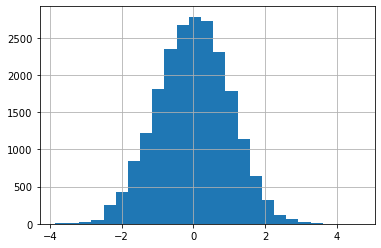

In [337]:
remove_outliers['sqft_living_log'].hist(bins=25)

In [474]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
remove_outliers.quantile(q=.9985)

sqft_living_log    3.025420
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
Name: 0.9985, dtype: float64

In [475]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
remove_outliers.quantile(q=.0015)

sqft_living_log   -2.882625
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
Name: 0.0015, dtype: float64

<AxesSubplot:>

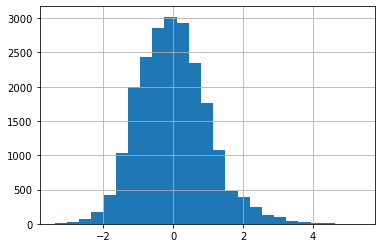

In [340]:
remove_outliers['price_log'].hist(bins=25)

In [341]:
# correlation before removing outliers
remove_outliers.corr()['price_log']['sqft_living_log']

0.674801656673277

In [342]:
remove_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sqft_living_log  21597 non-null  float64
 1   bathrooms_log    21597 non-null  float64
 2   bedrooms_log     21597 non-null  float64
 3   price_log        21597 non-null  float64
dtypes: float64(4)
memory usage: 675.0 KB


In [370]:
# remove rows with values in any column outside
# 3 standard deviations.

z_scores = stats.zscore(remove_outliers)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1, keepdims=True)
new_df = remove_outliers[filtered_entries]

new_df.shape

(21196, 4)

### Considering this removes data, I will use it on the final model to check if it is worth performing to reduce heteroscedasticity and increase normality.
* I may not remove outliers, because it is reducing the predictive capacity of the model.

In [358]:
# did the quantiles change? -Yes
print('Old df:', remove_outliers.quantile(q=.995))
print()
print('New df:', new_df.quantile(q=.995))

Old df: sqft_living_log    2.538945
bathrooms_log      2.105716
bedrooms_log       2.168119
price_log          3.159156
Name: 0.995, dtype: float64

New df: sqft_living_log    2.357324
bathrooms_log      2.105716
bedrooms_log       2.168119
price_log          2.656079
Name: 0.995, dtype: float64


In [350]:
# correlation after removing outliers.  Correlation decreased.
print('Sqft to Price - R^2 before removing outliers:',remove_outliers.corr()['price_log']['sqft_living_log'])
print('Sqft to Price - R^2 after removing outliers:',new_df.corr()['price_log']['sqft_living_log'])
print()
print('Sqft to Bathrooms - R^2 before removing outliers:',remove_outliers.corr()['price_log']['bathrooms_log'])
print('Sqft to Bathrooms - R^2 after removing outliers:',new_df.corr()['price_log']['bathrooms_log'])
print()
print('Sqft to Bedrooms - R^2 before removing outliers:',remove_outliers.corr()['price_log']['bedrooms_log'])
print('Sqft to Bedrooms - R^2 after removing outliers:',new_df.corr()['price_log']['bedrooms_log'])

Sqft to Price - R^2 before removing outliers: 0.674801656673277
Sqft to Price - R^2 after removing outliers: 0.6560120465950832

Sqft to Bathrooms - R^2 before removing outliers: 0.5202783301430879
Sqft to Bathrooms - R^2 after removing outliers: 0.4982833977384613

Sqft to Bedrooms - R^2 before removing outliers: 0.3428502794669042
Sqft to Bedrooms - R^2 after removing outliers: 0.3235855060609759


### Dropping Outliers reduces predictive capacity of model.
* How does it impact normality and heteroscedasticity?

## Replace Outliers

In [455]:
replace_out = pd.concat([first_model, features_add], axis=1)

replace_out.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,0.547946,-0.960852


In [472]:
# find cut-off for data outside 3 standard deviations (99.7% of data)
print('lower quantile:',replace_out.quantile(q=.0015))
print()
print('upper quantile:',replace_out.quantile(q=.9985))


lower quantile: sqft_living_log    0.009755
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
yr_built_log      -2.445050
floors_log        -0.960852
Name: 0.0015, dtype: float64

upper quantile: sqft_living_log    0.009755
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
yr_built_log       1.483389
floors_log         2.157851
Name: 0.9985, dtype: float64


In [476]:
# https://stackoverflow.com/questions/45386955/python-replacing-outliers-values-with-median-values
# http://localhost:8888/notebooks/t20/ds-feature_selection_and_feature_engineering-nbz32/feature_selection_and_feature_engineering.ipynb

median = replace_out['sqft_living_log'].median()

# replace lower threshold of sqft_living_log
replace_out["sqft_living_log"] = np.where(
    replace_out["sqft_living_log"] > -2.883, median,replace_out['sqft_living_log'])

# replace upper threshold of sqft_living_log
replace_out["sqft_living_log"] = np.where(
    replace_out["sqft_living_log"] < 3.025, median,replace_out['sqft_living_log'])


In [473]:
# find cut-off for data outside 3 standard deviations (99.7% of data)

print('lower quantile:',replace_out.quantile(q=.0015))
print()
print('upper quantile:',replace_out.quantile(q=.9985))


lower quantile: sqft_living_log    0.009755
bathrooms_log     -2.459491
bedrooms_log      -4.159448
price_log         -2.823059
yr_built_log      -2.445050
floors_log        -0.960852
Name: 0.0015, dtype: float64

upper quantile: sqft_living_log    0.009755
bathrooms_log      2.498475
bedrooms_log       2.712499
price_log          3.666191
yr_built_log       1.483389
floors_log         2.157851
Name: 0.9985, dtype: float64


In [468]:
# correlation after replacing outliers with mean
replace_out.corr()['price_log']['sqft_living_log']

-8.096569752015661e-17

## Product features
* Experimenting with 
* What would correlation be for product of bedrooms and bathrooms with price?

In [244]:
# product of bedrooms and bathrooms
remove_outliers['bd*ba'
                ] = remove_outliers['bedrooms_log'
                ] * remove_outliers['bathrooms_log']


In [245]:
# R-squared for product of bedrooms and bathrooms with price
remove_outliers.corr()['price_log']['bd*ba']

-0.004944805972521416

In [246]:
# R-squared for bedrooms and price
remove_outliers.corr()['price_log']['bedrooms_log']

0.3428502794669042

In [247]:
# R-squared for bathrooms and price
remove_outliers.corr()['price_log']['bathrooms_log']

0.5202783301430879

### Product of bedrooms and bathrooms reduces predictive capacity of model.

## Summary of Model - Outliers Removed

In [361]:
# Copy of Baseline Model Summary
X = features_final.drop(['price_log'], axis=1)
y = features_final['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     6414.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:09:59   Log-Likelihood:                -23764.
No. Observations:               21597   AIC:                         4.754e+04
Df Residuals:                   21593   BIC:                         4.757e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.343e-15      0.005   2.71e-13      1.000      -0.010       0.010
sqft_living_log     0.7572      0.008     89.141      0.000       0.741       0.774
bathrooms_log       0.0325      0.008      4.244      0.000       0.017       0.047
bedrooms_log       -0.1652      0.007    -25.342      0.000      -0.178      -0.152
==============================================================================
Omnibus:                      104.465   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.162
Skew:                           0.139   Prob(JB):                     2.93e-22
Kurtosis:                       2.820   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [362]:
# Model Summary with Outliers Removed
outliers_rem = new_df

X_OR = outliers_rem.drop(['price_log'], axis=1)
y_OR = outliers_rem['price_log']

X_int = sm.add_constant(X_OR)
model = sm.OLS(y_OR,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     5676.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:11:25   Log-Likelihood:                -22771.
No. Observations:               21196   AIC:                         4.555e+04
Df Residuals:                   21192   BIC:                         4.558e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0112      0.005     -2.294      0.022      -0.021      -0.002
sqft_living_log     0.7267      0.009     85.459      0.000       0.710       0.743
bathrooms_log       0.0309      0.008      4.109      0.000       0.016       0.046
bedrooms_log       -0.1666      0.007    -23.959      0.000      -0.180      -0.153
==============================================================================
Omnibus:                      144.407   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              109.390
Skew:                           0.083   Prob(JB):                     1.76e-24
Kurtosis:                       2.689   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Third Model - add more numerical values
* Which numerical values to add?
* Adds complexity and might hurt bias while improving variance.

In [248]:
# look at values for floors -- looks easy to implement
house_df['floors'].value_counts(dropna=False)

1.0    10673
2.0     8235
1.5     1910
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [249]:
# too many issues with this column - could probably one hot encode
# all of the years, but that would create too many predictors.
house_df['yr_renovated'].value_counts(dropna=False)

0.0       17011
NaN        3842
2014.0       73
2003.0       31
2013.0       31
          ...  
1944.0        1
1948.0        1
1976.0        1
1934.0        1
1953.0        1
Name: yr_renovated, Length: 71, dtype: int64

In [250]:
# look at yr_built value_counts - easy to include this predictor
house_df['yr_built'].value_counts(dropna=False)

2014    559
2006    453
2005    450
2004    433
2003    420
       ... 
1933     30
1901     29
1902     27
1935     24
1934     21
Name: yr_built, Length: 116, dtype: int64

In [251]:
add_numericals = house_df[['yr_built', 'floors']]

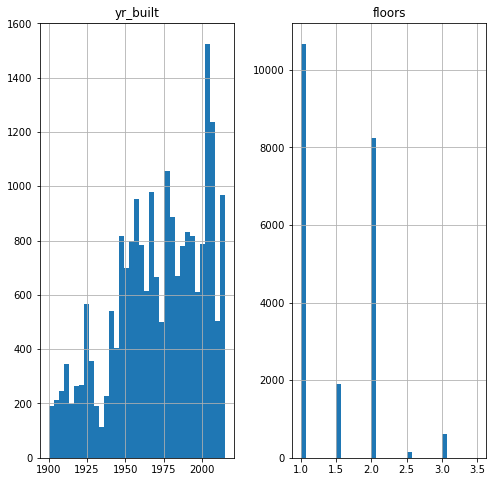

In [252]:
add_numericals.hist(figsize = [8,8], bins='auto');

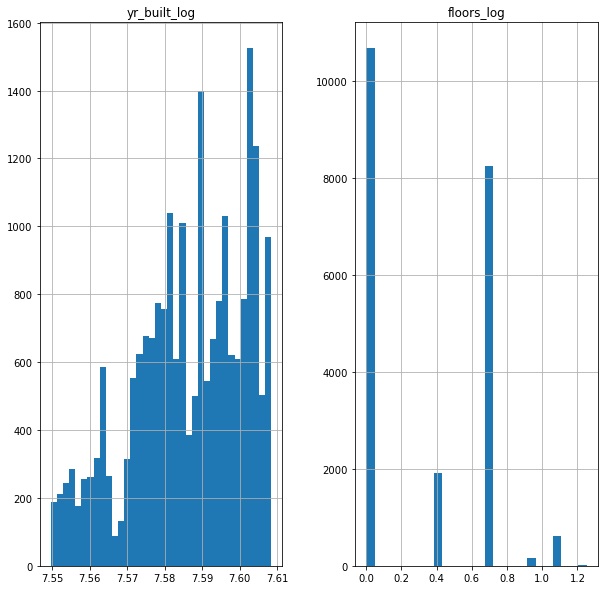

In [253]:
# Perform log transformations for add_numericals 

log_names = [f'{column}_log' for column in add_numericals.columns]

house_log = np.log(add_numericals)
house_log.columns = log_names
house_log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

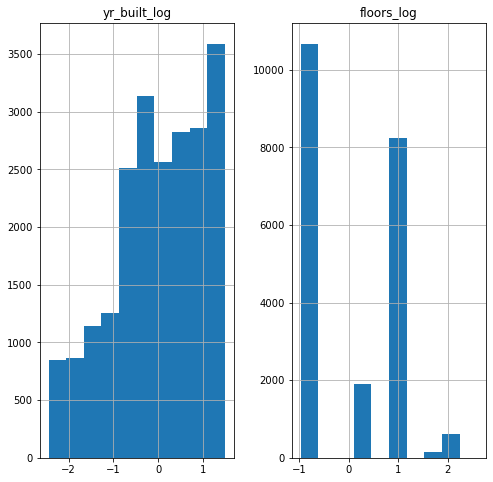

In [254]:
# Standardize the log features

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

features_add = house_log.apply(normalize)

features_add.hist(figsize  = [8, 8]);

### Additional features not normally distributed.
* Likely to cause skewness.

In [255]:
third_model = pd.concat([second_model, features_add], axis=1)
third_model.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,view_NONE,condition_Fair,...,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0.547946,-0.960852


In [256]:
# Model Summary
X = third_model.drop(['price_log'], axis=1)
y = third_model['price_log']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1811.
Date:                Wed, 23 Feb 2022   Prob (F-statistic):               0.00
Time:                        10:41:29   Log-Likelihood:                -19347.
No. Observations:               21597   AIC:                         3.874e+04
Df Residuals:                   21574   BIC:                         3.892e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1622      0.027     42.506      0.000       1.109       1.216
sqft_living_log         0.3183      0.008     37.644      0.000       0.302       0.335
bathrooms_log           0.1051      0.007     14.385      0.000       0.091       0.119
bedrooms_log           -0.0753      0.006    -13.587      0.000      -0.086      -0.064
water_1.0               0.6174      0.060     10.275      0.000       0.500       0.735
view_EXCELLENT          0.3314      0.045      7.374      0.000       0.243       0.419
view_FAIR               0.1558      0.038      4.114      0.000       0.082       0.230
view_GOOD               0.0785      0.033      2.407      0.016       0.015       0.143
view_NONE              -0.1946      0.020     -9.696      0.000      -0.234      -0.155
condition_Fair         -0.3082      0.046     -6.666      0.000      -0.399      -0.218
condition_Good          0.0279      0.010      2.780      0.005       0.008       0.048
condition_Very Good     0.1563      0.016      9.643      0.000       0.125       0.188
grade_11 Excellent      0.4015      0.035     11.559      0.000       0.333       0.470
grade_12 Luxury         0.8326      0.066     12.633      0.000       0.703       0.962
grade_13 Mansion        1.4383      0.166      8.662      0.000       1.113       1.764
grade_4 Low            -2.1558      0.118    -18.204      0.000      -2.388      -1.924
grade_5 Fair           -2.1173      0.047    -44.977      0.000      -2.210      -2.025
grade_6 Low Average    -1.7577      0.029    -61.252      0.000      -1.814      -1.701
grade_7 Average        -1.3080      0.023    -57.594      0.000      -1.353      -1.264
grade_8 Good           -0.8744      0.021    -42.062      0.000      -0.915      -0.834
grade_9 Better         -0.3916      0.021    -18.331      0.000      -0.433      -0.350
yr_built_log           -0.3198      0.005    -58.362      0.000      -0.331      -0.309
floors_log              0.0726      0.005     14.182      0.000       0.063       0.083
==============================================================================
Omnibus:                       54.593   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.004
Skew:                          -0.069   Prob(JB):                     2.08e-14
Kurtosis:                       3.226   Cond. No.                         71.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Train, Test, Split
* Use cats_added, the most predictive model, to train, test, and split.

In [257]:
first_model = features_final
second_model = cats_added

## First Model - Train, Test, Split

In [258]:
X = first_model.drop('price_log', axis=1)
y = first_model['price_log']

In [259]:
# Split the data into training and test sets. Changed split size based on 
# the evaluation of train-test-split size below.  40% test size had a lower
# average variance than 25% or 30%.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [260]:
linreg = LinearRegression()

In [261]:
# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [262]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [263]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [264]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.5254359407772006
Test Mean Squared Error: 0.5108396021004958


## Second Model - Train, Test, Split

In [265]:
X2 = second_model.drop('price_log', axis=1)
y2 = second_model['price_log']

In [266]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X2,y2, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [267]:
# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [268]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [269]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [270]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.40930618138018565
Test Mean Squared Error: 0.40462394289018844


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [271]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.5957662581741421

## Evaluate the effect of train-test split size.

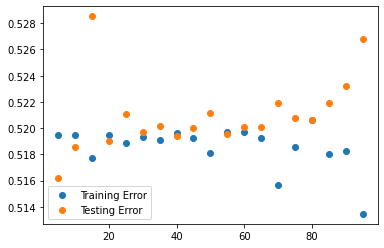

In [272]:
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()

### Model improvements from first to second models.
* Lower variance and lower bias present in second_model compared to first_model
    * Adjusted R-squared improved from 0.471 to 0.592
    * Mean Squared Error improved from 0.507/0.516 (train/test) to 0.404/0.413 (train/test).
***
* Mean squared error similar in train and test splits for both first and second models.
    * first_model: train = 0.507, test = 0.516
    * second_model: train = 0.404, test = 0.413

## Third Model - added numericals
* yr_built and floors added to model as they correlate somewhat to price and have clean data.

In [273]:
X3 = third_model.drop('price_log', axis=1)
y3 = third_model['price_log']

In [274]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X3,y3, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [275]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [276]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [277]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [278]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.3523901685672192
Test Mean Squared Error: 0.35032727736463953


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [279]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.6524410176851816

### Third model lowers Variance and Bias
* Adjusted R-squared value increased from 0.587 to .642
* Root Mean Squared Error (RMSE) decreased from 0.404/0.413 (train/test) to 0.351/0.353 (train/test)

## Fourth Model
* Drop predictors with high VIF scores
    * view_NONE
    * grade_7 Average

In [284]:
fourth_model = third_model.drop(['view_NONE', 'grade_7 Average'], axis=1)

fourth_model.head()

,sqft_living_log,bathrooms_log,bedrooms_log,price_log,water_1.0,view_EXCELLENT,view_FAIR,view_GOOD,condition_Fair,condition_Good,...,grade_11 Excellent,grade_12 Luxury,grade_13 Mansion,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_8 Good,grade_9 Better,yr_built_log,floors_log
0,-1.125556,-1.726509,-0.279718,-1.401998,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.537409,-0.960852
1,0.709446,0.339653,-0.279718,0.279938,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.674325,1.006831
2,-2.131893,-1.726509,-1.711611,-1.799430,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-1.293945,-0.960852
3,0.070674,1.072635,0.736226,0.499698,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.196338,-0.960852
4,-0.292725,0.039555,-0.279718,0.178434,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.547946,-0.960852


In [445]:
X4 = fourth_model.drop('price_log', axis=1)
y4 = fourth_model['price_log']

In [446]:
# Split the data into training and test sets. Use the default split size

X_train, X_test, y_train, y_test = train_test_split(X4,y4, test_size=.4)

# A brief preview of tts
print(len(X_train), len(X_test), len(y_train), len(y_test))

12958 8639 12958 8639


In [447]:
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression()

In [448]:
# Calculate predictions on training and test sets
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [449]:
# Calculate residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [450]:
# Calculate training and test MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 0.40236996733858676
Test Mean Squared Error: 0.4171104849991408


### Instantiate a Linear Regression model called final_model, then fit it to training data and score it on test data.

In [451]:
final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model.fit(X_train, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
final_model.score(X_test, y_test)

0.5814655470370985

### Fourth Model reduces fit and increases RMSE.
* The fourth model is not as accurate of a predictor, but it reduces multicollinearity and therefore produces more reliable predictions.

# Interpret the Final Model

## Investigating Normality

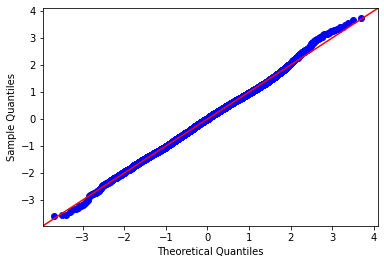

In [452]:
import scipy.stats as stats

preds = final_model.predict(X_test)

residuals = (y_test - preds)
sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);

### Normality Assumption Met
* Removing the outlier values did not improve the predictive capacity of this model.

## Investigating Multicollinearity (independence assumption)

In [453]:
# estimate multicollinarity with Variance Inflation Factor (VIF)
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

sqft_living_log        3.515491
bathrooms_log          3.231453
bedrooms_log           1.819730
water_1.0              1.537733
view_EXCELLENT         1.581141
view_FAIR              1.024577
view_GOOD              1.058992
condition_Fair         1.030085
condition_Good         1.319723
condition_Very Good    1.160107
grade_11 Excellent     1.147671
grade_12 Luxury        1.069908
grade_13 Mansion       1.012970
grade_4 Low            1.028081
grade_5 Fair           1.075985
grade_6 Low Average    1.341758
grade_8 Good           1.262110
grade_9 Better         1.317531
yr_built_log           1.769886
floors_log             1.562873
Name: Variance Inflation Factor, dtype: float64

### Removed predictors with score greater than 5
* view_NONE (12.4)
* grade_7 Average (7.42)

## Investigating Homoscedasticity

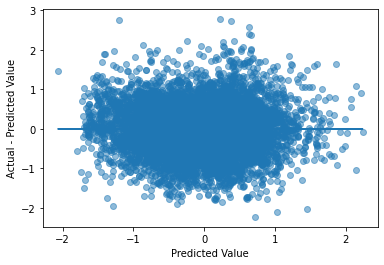

In [444]:
fig, ax = plt.subplots()

ax.scatter(preds, residuals, alpha=0.5)
ax.plot(preds, [0 for i in range(len(X_test))])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Actual - Predicted Value");

### Homoscedasticity assumption is met
* Removing a few outliers could improve the distribution.

## Linear Regression Assumptions Conclusion

## Interpreting Values

In [483]:
interpret_1 = house_df[['price', 
                     'sqft_living', 
                     'bathrooms',
                     'bedrooms',
                     'yr_built',
                     'floors']]

interpret_2 = pd.concat([interpret_1, cats_added])

interpret_2.drop(['view_NONE', 'grade_7 Average']

interpret_2.info()

SyntaxError: invalid syntax (<ipython-input-483-c3fdf317ead4>, line 12)

# Recommendations

## Renovate Interior
* Grade and Condition score increases were highly correlated to price increases.
* Spending on an interior renovation, especially in regards to the whole house being considered very good to luxury is likely to increase sale price.

## Create a View
* Add larger windows that face pleasant scenery.
* Add a deck or rooftop deck to enhance access to outdoor views.
* Landscape and design views from windows to include desirable plants and scenery.

## Add Square Footage
* Not necessarily bedrooms or bathrooms, though it is better to add bathrooms, in terms of sale price.
* Add a guest cottage with full pluming, electrical, and HVAC.
* Renovate Garage to be fully insulated livable space.

# Future Work

## Examine other housing data sets to determine if they contain similar trends to predictors in the King County Data Set.

## Find additional predictors to better estimate how much certain home changes alter sale price. 
* Type of remodel or home additions.
    * Ex. Kitchen, Garage, Patio, additional Bedrooms/Bathrooms.

## Estimate return on investment for certain projects.
* How do certain project appreciate over time?
* Is it better to spend more to make more, or is there a certain level of spending that reaps a higher gain?

In [337]:
"""
I am very curious about making the label encoder 
work with numbers that I determine.

I wonder if the label encoder will produce different results
than the one hot encoder in terms of the R-squared
and variance.
"""

'\nI am very curious about making the label encoder \nwork with numbers that I determine.\n\nI wonder if the label encoder will produce different results\nthan the one hot encoder in terms of the R-squared\nand variance.\n'

In [ ]:
# This is where I left off 2/21 - need to do ohe for grade
# need to remove 1 column for each ohe variable due to 
# multicollinearity
# next add these to baseline model
# move into train, test, split for model to check how well
# it performs.

# not too many other categories to add, but could do some
# engineering/modification of numerical columns to adjust
# for outliers

# then establish recommendations for renovations.

In [106]:
view_df.value_counts(dropna=False)

NameError: name 'view_df' is not defined

In [ ]:
# failing to drop nan values from categoricals['view']
# categoricals.dropna(subset=['view'], inplace=True)

In [ ]:
# Trying to use default dict to replace values 

# import collections
# d = collections.defaultdict(lambda:0)
# d["NONE"] = 0
# d["AVERAGE"] = 1
# d["GOOD"] = 2
# d["FAIR"] = 3
# d["EXCELLENT"] = 4

# print(d["NONE"])

In [ ]:
view_df.replace(to_replace ="NONE", 

view_df.replace(to_replace =["NONE"], value ="0")

In [ ]:
view_df = categoricals['view'].astype('str')

view_df.replace({"NONE": "0", 
                            "AVERAGE": 1,
                            "GOOD": 2, 
                            "FAIR": 3, 
                            "EXCELLENT": 4})

view_df.value_counts(dropna=False)

In [ ]:
cat_new.head()

In [ ]:
cat_new.to_frame()

In [ ]:
categoricals.info()

In [ ]:
d_frames = [cat_new, categoricals]

# all_cats = pd.concat(d_frames, axis=0, join='outer')
categoricals.join(cat_new, lsuffix='grade', rsuffix='view')

all_cats.head()

In [ ]:
all_cats.shape

In [ ]:
categoricals.head()

In [ ]:
le = LabelEncoder()

cat_view = categoricals['view'].astype('str')

le.fit(cat_view)
le.transform(cat_view)


In [ ]:
# Remove nan values from cat_view
cat_view.dropna()
cat_view.value_counts()

In [ ]:
# Encode view categories to numericals
view_encoded = lb_make.fit_transform(cat_view)

view_encoded

In [ ]:
cat_view.value_counts()

In [ ]:
view_df = pd.DataFrame(view_encoded)
view_df.value_counts()